__To run the following analysis please download the full dataset from https://doi.org/10.5281/zenodo.15807706 and place the extracted folder in the root directory of the project__

In [1]:
!pip install -q matplotlib==3.9.4
!pip install -q fastplot
!pip install -q numpy==1.23.3
!pip install -q pandas==1.5.0
!pip install -q seaborn==0.12.0
!pip install -q cvss==3.4

In [2]:
import pandas as pd
from datetime import datetime
import fastplot
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statistics
from cvss import CVSS2, CVSS3, CVSS4
from cycler import cycler
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='fastplot')

In [3]:
PLOT_ARGS = {'style': 'latex',
             'grid': True,
             'figsize': (6, 3),
             'rcParams': {'text.latex.preamble': r'\usepackage{amsmath}'},
             'xtick_direction': 'out',
             'ytick_direction': 'out',
             'xtick_width': 0.8,
             'ytick_width': 0.8,
             'xtick_length': 3.5,
             'ytick_length': 3.5,
            }

YEARS = [2021, 2022, 2023, 2024]
DAY_UPPER_BOUND = pd.to_datetime('2024-09-30 23:59').date()

# Data loading

In [4]:
dataset_path = 'datasets/cve_c-2024-10-01_o-2024-10-01'

df_info_cvss = pd.read_csv(f'{dataset_path}/cve_info_21-24_cvss_f.csv')
df_info_cvss['reserved'] = pd.to_datetime(df_info_cvss['reserved'], utc=True).dt.tz_localize(None)
df_info_cvss['published'] = pd.to_datetime(df_info_cvss['published'], utc=True).dt.tz_localize(None)
df_info_cvss['rejected'] = pd.to_datetime(df_info_cvss['rejected'], utc=True).dt.tz_localize(None)

df_changes = pd.read_csv(f'{dataset_path}/cve_changes_21-24_f.csv')
df_changes['created'] = pd.to_datetime(df_changes['created'], utc=True).dt.tz_localize(None)

df_feed = pd.read_csv(f'{dataset_path}/cve_feed_21-24_f.csv')
df_feed['reserved'] = pd.to_datetime(df_feed['reserved'], utc=True).dt.tz_localize(None)
df_feed['published'] = pd.to_datetime(df_feed['published'], utc=True).dt.tz_localize(None)

In [5]:
id_rejected = set(df_info_cvss[df_info_cvss['vulnStatus'] == 'Rejected']['id'])
df_info_cvss_full = df_info_cvss.copy()
df_info_cvss_rejected = df_info_cvss[df_info_cvss['id'].isin(id_rejected)].copy()
df_info_cvss = df_info_cvss[~df_info_cvss['id'].isin(id_rejected)]

df_changes_full = df_changes.copy()
df_changes_rejected = df_changes[df_changes['cveId'].isin(id_rejected)].copy()
df_changes = df_changes[~df_changes['cveId'].isin(id_rejected)]

# Analysis

## Cardinality

In [6]:
df_card = pd.DataFrame(index=['feed', 'info', 'changes'], 
                       columns=['#cve', '#published', '#rejected'])
df_card.loc['feed'] = [df_feed['id'].nunique(),
                       df_feed[df_feed['vulnStatus'] == 'PUBLISHED']['id'].nunique(), 
                       df_feed[df_feed['vulnStatus'] == 'REJECTED']['id'].nunique()]
df_card.loc['info'] = [df_info_cvss_full['id'].nunique(),
                       df_info_cvss['id'].nunique(), 
                       df_info_cvss_rejected['id'].nunique()]
df_card.loc['changes'] = [df_changes_full['cveId'].nunique(), 
                          df_changes['cveId'].nunique(), 
                          df_changes_rejected['cveId'].nunique()]
df_card

,#cve,#published,#rejected
feed,96084,95119,965
info,95913,94949,964
changes,95913,94949,964


<Figure size 640x480 with 0 Axes>

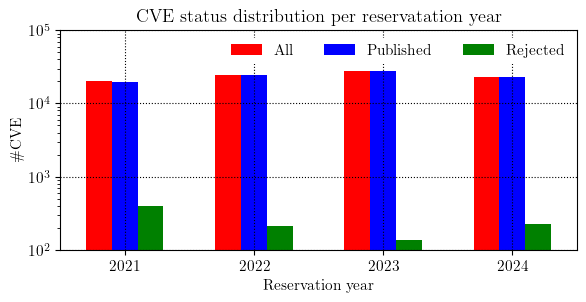

In [7]:
df = df_info_cvss_full.drop_duplicates(subset=['id'])
full = df.groupby('reservationYear').size()
pub = df[df['vulnStatus'] != 'Rejected'].groupby('reservationYear').size()
rej = df[df['vulnStatus'] == 'Rejected'].groupby('reservationYear').size()
lists = [[full[y], pub[y], rej[y]] for y in YEARS]
data = pd.DataFrame(lists, index=YEARS, columns=['All', 'Published', 'Rejected'])
plot = fastplot.plot(data, None, mode='bars_multi', xlabel='Reservation year', ylabel='\#CVE', yscale='log',
                     legend=True, legend_ncol=3, **PLOT_ARGS)
plot.title('CVE status distribution per reservatation year')
plot.show()

<Figure size 640x480 with 0 Axes>

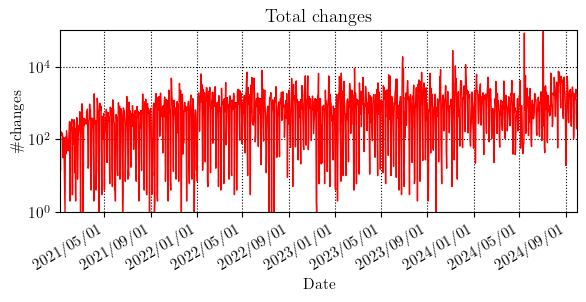

<Figure size 640x480 with 0 Axes>

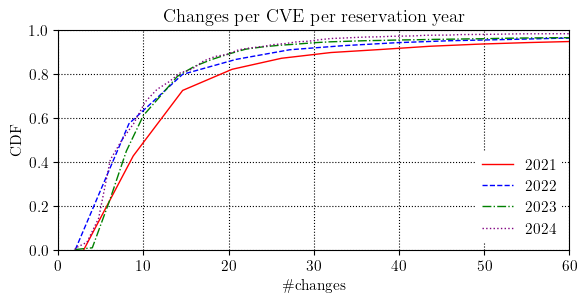

In [8]:
plot = fastplot.plot(df_changes.groupby(df_changes['created'].dt.date).size(), None, mode='timeseries', 
                     xlabel='Date', ylabel='\#changes', xticks_rotate=30, yscale='log', **PLOT_ARGS)
plot.title('Total changes')
plot.show()

data = [(str(y), df_changes[df_changes['reservationYear'] == y]
                          .groupby('cveId')
                          .size()
                          .tolist()) 
        for y in YEARS]
plot = fastplot.plot(data, None, mode='CDF_multi', xlabel='\#changes', xlim=(0, 60), legend=True, **PLOT_ARGS)
plot.title('Changes per CVE per reservation year')
plot.show()

<Figure size 640x480 with 0 Axes>

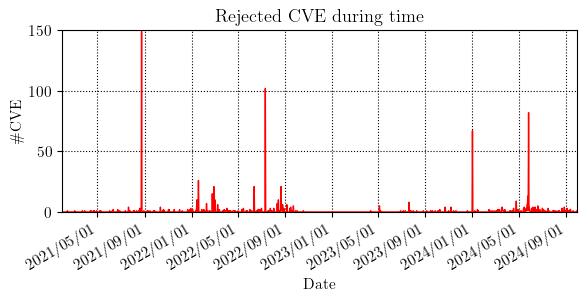

In [9]:
data_series = df_info_cvss_rejected.drop_duplicates(subset=['id']).groupby(df_info_cvss_rejected['rejected'].dt.date).size()
date_range = pd.date_range(start=min(data_series.index), end=max(data_series.index))
filled_series = data_series.reindex(date_range, fill_value=0)
plot = fastplot.plot(filled_series, None, mode='timeseries', xlabel='Date', ylabel='\#CVE', 
                     xticks_rotate=30, **PLOT_ARGS)
plot.title('Rejected CVE during time')
plot.show()

Median number of publications per day
 reservationYear
2021    20.0
2022    18.0
2023    30.0
2024    68.0
dtype: float64


<Figure size 640x480 with 0 Axes>

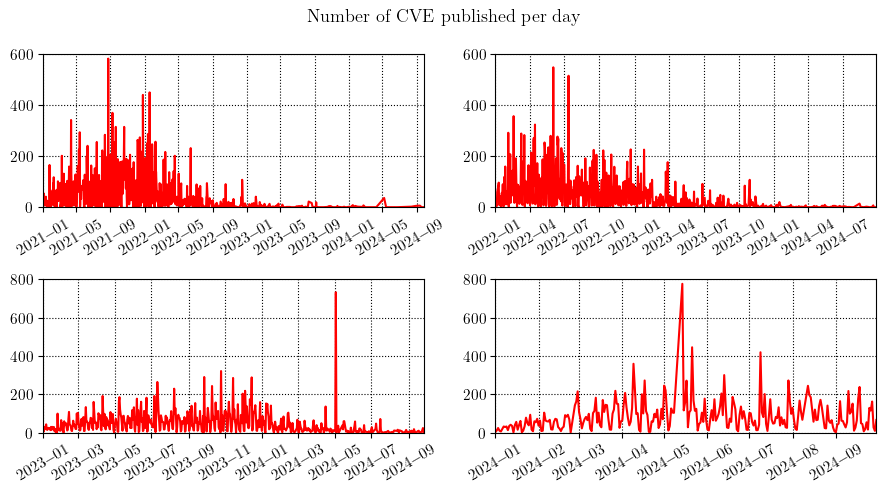

In [10]:
def st_callback(plt):
    plt.close()
    fig, axs = plt.subplots(2, 2, figsize=(9, 5))
    for i, y in enumerate([2021, 2022, 2023, 2024]):
        ax = axs[i // 2, i % 2]
        ax.plot(tss[y].index, tss[y].values)
        ax.grid(True, which='major', axis='both', linestyle='dotted', color='black')
        ax.tick_params(axis='x', rotation=30)
    fig.suptitle('Number of CVE published per day')
        

grouped = df_info_cvss_full.groupby('reservationYear')
tss = grouped.apply(lambda x: x.groupby(x.published.dt.date).size())
print('Median number of publications per day\n', grouped.apply(lambda x: x.groupby(x.published.dt.date).size().median()))
fastplot.plot(None, None, mode='callback', callback=st_callback, **PLOT_ARGS).show()

<Figure size 640x480 with 0 Axes>

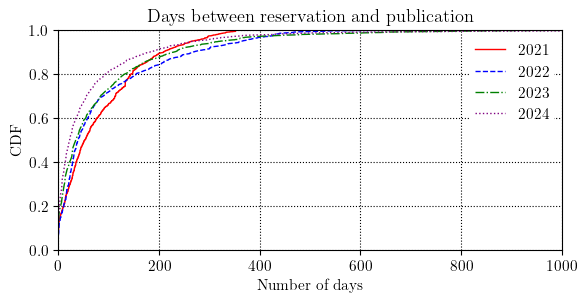

published
2021    53.0
2022    39.0
2023    35.0
2024    22.0
Name: daysDiff, dtype: float64

52.79% more than 30 days
3.04% more than 1 year



year                 2021.0
month                   8.0
median_difference      96.0
Name: 7, dtype: float64

In [11]:
df = df_info_cvss_full.drop_duplicates(subset=['id']).dropna(subset=['reserved', 'published'])[['id', 'reservationYear', 'reserved', 'published']]
df['daysDiff'] = (df['published'].dt.date - df['reserved'].dt.date).dt.days
data = [(str(y), df.groupby(df.published.dt.year)['daysDiff'].apply(list)[y]) for y in YEARS]
plot = fastplot.plot(data, None, mode='CDF_multi', xlabel='Number of days', legend=True, xlim=(0, 1000), **PLOT_ARGS)
plot.title('Days between reservation and publication')
plot.show()

print(df.groupby(df.published.dt.year)['daysDiff'].median())
df = df[df.published.dt.year >= 2021]
month_median = df.groupby([df['published'].dt.year.rename('year'), df['published'].dt.month.rename('month')])['daysDiff'].median().reset_index(name='median_difference')
print(f'\n{round(df[df.daysDiff > 30].id.nunique() / df.id.nunique() * 100, 2)}% more than 30 days')
print(f'{round(df[df.daysDiff > 365].id.nunique() / df.id.nunique() * 100, 2)}% more than 1 year\n')
month_median.loc[month_median.median_difference.idxmax()]

99.48% have both dates


<Figure size 640x480 with 0 Axes>

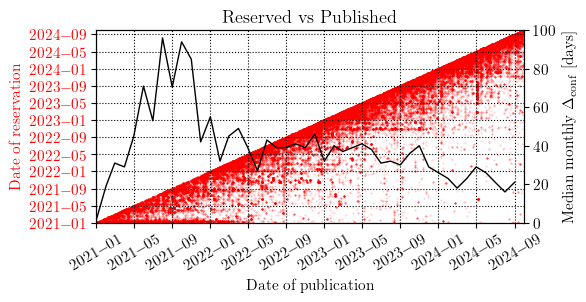

In [12]:
cc = (cycler('color',['k', 'r', 'b', 'g', 'y', 'm', 'c']) +
      cycler('linestyle',['-', '--', '-.', ':', '-', '--', '-.']))

def res_vs_pub_scatter_callback(plt):
    df = df_info_cvss_full.drop_duplicates(subset=['id']).dropna(subset=['reserved', 'published'])[['id', 'reserved', 'published']]
    print(f'{round(df.id.nunique() / df_info_cvss_full.id.nunique() * 100, 2)}% have both dates')
    plt.close()
    
    fig, ax1 = plt.subplots(figsize=(6, 3))
    ax1.set_xlabel('Date of publication')
    ax1.yaxis.label.set_color('red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.set_ylabel('Date of reservation')
    ax1.grid(True, which='major', axis='both', linestyle='dotted', color='black')
    ax1.scatter(df['published'].dt.date.tolist(), df['reserved'].dt.date.tolist(), alpha=0.2, s=0.2)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Median monthly $\Delta_{\\text{conf}}$ [days]')
    first_days = [datetime(y, m, 1) for y in range(2021, 2025) for m in range(1, 13) if datetime(y, m, 1) <= datetime(2024, 9, 30)]
    ax2.plot(first_days, month_median.median_difference.tolist(), c='black', linewidth=1)
    plt.setp(ax1.get_xticklabels(), rotation=30)

    
plot = fastplot.plot(None, None, mode='callback', callback=res_vs_pub_scatter_callback, **PLOT_ARGS)
plot.title('Reserved vs Published')
plot.show()

## Delays in CVEs status

### Reservation and publication

<Figure size 640x480 with 0 Axes>

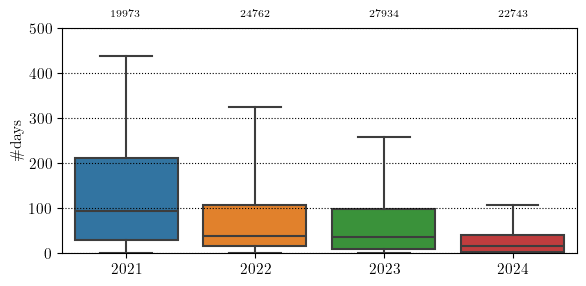

Number of CVEs with both dates:  95412
Number of CVEs with negative delay:  0


In [13]:
df = df_info_cvss_full[['id', 'reserved', 'published', 'reservationYear']].drop_duplicates(subset=['id']).dropna()
df['daysToPublication'] = (df['published'].dt.date - df['reserved'].dt.date).dt.days

data = [(str(y), df[df['daysToPublication'] >= 0].groupby('reservationYear')['daysToPublication'].apply(list)[y]) for y in YEARS]
plot = fastplot.plot(data, None, mode='boxplot', ylabel='\#days', boxplot_numerousness=True, **PLOT_ARGS)
plot.show()
print('Number of CVEs with both dates: ', len(df))
print('Number of CVEs with negative delay: ', len(df[df['daysToPublication'] < 0]))

### Reservation and rejection

<Figure size 640x480 with 0 Axes>

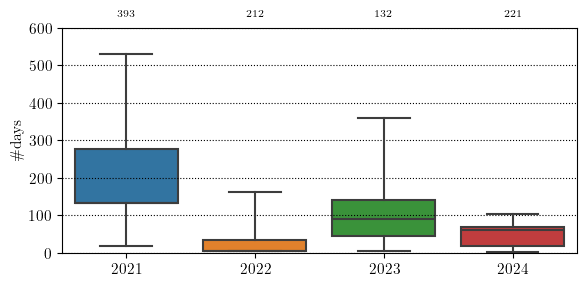

Number of CVEs with both dates:  958
Number of CVEs with negative delay:  0


In [14]:
df = df_info_cvss_rejected[['id', 'reserved', 'rejected', 'reservationYear']].drop_duplicates(subset=['id']).dropna()
df['daysToRejection'] = (df['rejected'].dt.date - df['reserved'].dt.date).dt.days

data = [(str(y), df.groupby('reservationYear')['daysToRejection'].apply(list)[y]) for y in YEARS]
plot = fastplot.plot(data, None, mode='boxplot', ylabel='\#days', boxplot_numerousness=True, **PLOT_ARGS)
plot.show()
print('Number of CVEs with both dates: ', len(df['id']))
print('Number of CVEs with negative delay: ', len(df[df['daysToRejection'] < 0]))

### Publication and rejection

<Figure size 640x480 with 0 Axes>

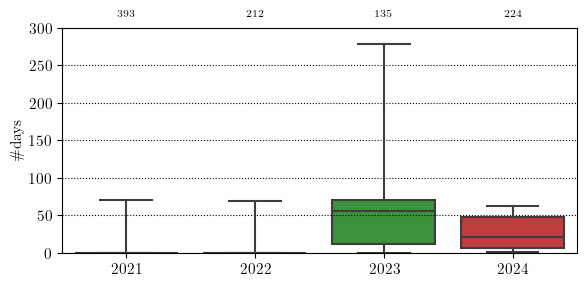

Number of CVEs with both dates:  964
Number of CVEs with negative delay:  0


In [15]:
df = df_info_cvss_rejected[['id', 'published', 'rejected', 'reservationYear']].drop_duplicates(subset=['id']).dropna()
df['daysPubRej'] = (df['rejected'].dt.date - df['published'].dt.date).dt.days

data = [(str(y), df.groupby('reservationYear')['daysPubRej'].apply(list)[y]) for y in YEARS]
plot = fastplot.plot(data, None, mode='boxplot', ylabel='\#days', boxplot_numerousness=True, **PLOT_ARGS)
plot.show()
print('Number of CVEs with both dates: ', len(df['id']))
print('Number of CVEs with negative delay: ', len(df[df['daysPubRej'] < 0]))

## CVSS

In [16]:
POSSIBLE_CVSS = ['CVSS V2', 'CVSS V3', 'CVSS V3.1', 'CVSS V4.0']
cvss_naming_mapping = {
    POSSIBLE_CVSS[0]: 2.0,
    POSSIBLE_CVSS[1]: 3.0,
    POSSIBLE_CVSS[2]: 3.1,
    POSSIBLE_CVSS[3]: 4.0,
}

df_changes_cvss = df_changes[(df_changes['changeType'] == 'CVSS') &\
                            (df_changes['action'].astype(str).str.contains('Added'))][['cveId', 'sourceIdentifier', 'created', 'type', 'newValue']]
df_changes_cvss = df_changes_cvss[~df_changes_cvss.type.astype(str).str.contains('Metadata')]
df_changes_cvss['cvssVersion'] = df_changes_cvss['type'].map(cvss_naming_mapping)

df_changes_cvss.sort_values(['cveId', 'created', 'cvssVersion'], ascending=[True, True, False], inplace=True)
df_first_cvss = df_changes_cvss.loc[df_changes_cvss.groupby('cveId').head(1).index]
df_first_cvss = df_first_cvss[['cveId', 'created', 'newValue', 'cvssVersion']]
df_first_cvss.rename(columns={'cveId': 'id', 'newValue': 'cvssVectorString', 'created': 'cvssCreated'}, inplace=True)

missing_cvss = set(df_changes.cveId) - set(df_first_cvss.id)
df_info_cvss_merging = df_info_cvss[df_info_cvss.id.isin(missing_cvss)][['id', 'cvssVectorStringPrimary', 'cvssVersionPrimary']]
df_info_cvss_merging.rename(columns={'cvssVectorStringPrimary': 'cvssVectorString', 'cvssVersionPrimary': 'cvssVersion'}, inplace=True)
df_cvss = pd.merge(df_first_cvss, df_info_cvss_merging, how='outer')

df_info_cvss_merging = df_info_cvss.drop_duplicates(subset=['id'])[['id', 'reserved', 'reservationYear', 'published']]
df_cvss = pd.merge(df_cvss, df_info_cvss_merging, on=['id'], how='inner')

df_cvss['daysToCVSS'] = (df_cvss['cvssCreated'].dt.date - df_cvss['published'].dt.date).dt.days

In [17]:
def add_version_to_vector_cvss(row):
    if pd.notna(row['cvssVectorString']) and pd.notna(row['cvssVersion']):
        if row['cvssVersion'] != 2.0:
            return ''.join([f'CVSS:{str(row["cvssVersion"])}', '/', row['cvssVectorString']])
        else:
            return row['cvssVectorString']
    

wrong_cvss = []
def cvss_base_score(row):
    if pd.notna(row['cvssVersion']):
        try:
            if row['cvssVersion'] == 2.0:
                return CVSS2(row['cvssVectorStringFull']).base_score
            elif row['cvssVersion'] == 4.0:
                return CVSS4(row['cvssVectorStringFull']).base_score
            elif row['cvssVersion'] in [3.0, 3.1]:
                return CVSS3(row['cvssVectorStringFull']).base_score
            else:
                return None
        except:
            wrong_cvss.append(row.id)
    else:
        return np.nan


df_cvss['cvssVectorStringFull'] = df_cvss.apply(add_version_to_vector_cvss, axis=1)
df_cvss['cvssBaseScore'] = df_cvss.apply(cvss_base_score, axis=1)
df_cvss['cvssBaseScore'] = df_cvss['cvssBaseScore'].astype(float)

df_cvss.info()
without_date_cvss = len(df_cvss.dropna(subset=['cvssVersion']).cvssVersion) - len(df_cvss.dropna(subset=['cvssCreated']).cvssCreated)
print(f'\nWithout cvssCreated: {round(without_date_cvss / len(df_cvss.cvssVersion) * 100, 2)}% ({without_date_cvss})')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94949 entries, 0 to 94948
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    94949 non-null  object        
 1   cvssCreated           89121 non-null  datetime64[ns]
 2   cvssVectorString      91517 non-null  object        
 3   cvssVersion           91517 non-null  float64       
 4   reserved              94454 non-null  datetime64[ns]
 5   reservationYear       94949 non-null  int64         
 6   published             94949 non-null  datetime64[ns]
 7   daysToCVSS            89121 non-null  float64       
 8   cvssVectorStringFull  91517 non-null  object        
 9   cvssBaseScore         91517 non-null  float64       
dtypes: datetime64[ns](3), float64(3), int64(1), object(3)
memory usage: 8.0+ MB

Without cvssCreated: 2.52% (2396)


### Base score

In [18]:
bins = [0, 0.1, 4.0, 7.0, 9.0, 10.1]
labels = ['None', 'Low', 'Medium', 'High', 'Critical']
df_cvss['range'] = pd.cut(df_cvss.dropna(subset=['cvssBaseScore'])['cvssBaseScore'], bins=bins, right=False, labels=labels, include_lowest=True)
df_cvss['range'].value_counts().sort_index()

None           22
Low          2421
Medium      41149
High        34486
Critical    13439
Name: range, dtype: int64

In [19]:
id_current = set()
with open('datasets/cve_ids/id_current.txt', 'r') as f:
    for l in f.readlines():
        id_current.add(l.strip())

filtered_df = df_cvss[df_cvss.id.isin(id_current)]

counts = filtered_df['range'].value_counts().sort_index()
total = counts.sum()
percentages = (counts / total) * 100

result = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages
})
result['Percentage'] = result['Percentage'].round(2)

result

,Count,Percentage
None,22,0.05
Low,1372,3.28
Medium,20219,48.39
High,14757,35.32
Critical,5412,12.95


In [20]:
id_current_above = set()
with open('datasets/cve_ids/id_current_above.txt', 'r') as f:
    for l in f.readlines():
        id_current_above.add(l.strip())

filtered_df = df_cvss[df_cvss.id.isin(id_current_above)]

counts = filtered_df['range'].value_counts().sort_index()
total = counts.sum()
percentages = (counts / total) * 100

result = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages
})
result['Percentage'] = result['Percentage'].round(2)

print(filtered_df.cvssBaseScore.median(), filtered_df.cvssBaseScore.min(), filtered_df.cvssBaseScore.max())
result

9.8 5.3 10.0


,Count,Percentage
None,0,0.00
Low,0,0.00
Medium,9,6.57
High,41,29.93
Critical,87,63.50


In [21]:
id_kev_current = set()
with open('datasets/cve_ids/id_kev_current.txt', 'r') as f:
    for l in f.readlines():
        id_kev_current.add(l.strip())
        
filtered_df = df_cvss[df_cvss.id.isin(id_kev_current)]

counts = filtered_df['range'].value_counts().sort_index()
total = counts.sum()
percentages = (counts / total) * 100

result = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages
})
result['Percentage'] = result['Percentage'].round(2)

result

,Count,Percentage
None,0,0.00
Low,0,0.00
Medium,27,14.84
High,99,54.40
Critical,56,30.77


In [22]:
filtered_df = df_cvss[df_cvss.id.isin(id_current_above & id_kev_current)]

counts = filtered_df['range'].value_counts().sort_index()
total = counts.sum()
percentages = (counts / total) * 100

result = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages
})
result['Percentage'] = result['Percentage'].round(2)

result

,Count,Percentage
None,0,0.00
Low,0,0.00
Medium,3,5.17
High,19,32.76
Critical,36,62.07


### Main analysis

[('2021', 2), ('2022', 25), ('2023', 215), ('2024', 3190)]


<Figure size 640x480 with 0 Axes>

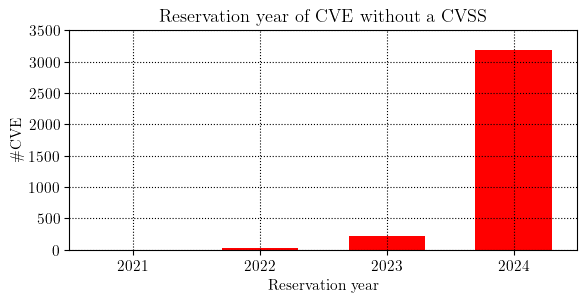

<Figure size 640x480 with 0 Axes>

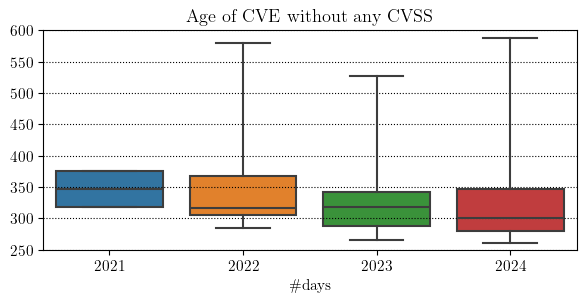

In [23]:
df_info_cvss_no_cvss = df_cvss[df_cvss.cvssVersion.isna()]
years = df_info_cvss_no_cvss.groupby(df_info_cvss_no_cvss.reservationYear).size().index

no_cvss_size = df_info_cvss_no_cvss.groupby('reservationYear').size()
data = [(str(y), no_cvss_size[y]) for y in years]
print(data)
plot = fastplot.plot(data, None, mode='bars', xlabel='Reservation year', ylabel='\#CVE', **PLOT_ARGS)
plot.title('Reservation year of CVE without a CVSS')
plot.show()

df_age = df_info_cvss_no_cvss.copy()
df_age['age'] = (DAY_UPPER_BOUND - df_info_cvss['reserved'].dt.date).dt.days
data = [(str(y), df_age.groupby('reservationYear')['age'].apply(list)[y]) for y in years]
plot = fastplot.plot(data, None, mode='boxplot', xlabel='\#days', **PLOT_ARGS)
plot.title('Age of CVE without any CVSS')
plot.show()

<Figure size 640x480 with 0 Axes>

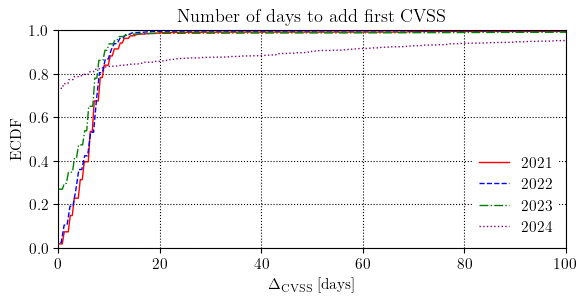

2021 6.0
2022 6.0
2023 5.0
2024 0.0


In [24]:
data = [(str(y), df_cvss.dropna(subset=['daysToCVSS']).groupby('reservationYear')['daysToCVSS'].apply(list)[y]) for y in range(2021, 2025)]
plot = fastplot.plot(data, None, mode='CDF_multi', xlabel='$\\Delta_{\\text{CVSS}}$ [days]', xlim=(0, 100), 
                     ylabel='ECDF', legend=True, **PLOT_ARGS)
plot.title('Number of days to add first CVSS')
plot.show()

for e in data:
    print(e[0], statistics.median(e[1]))

<Figure size 640x480 with 0 Axes>

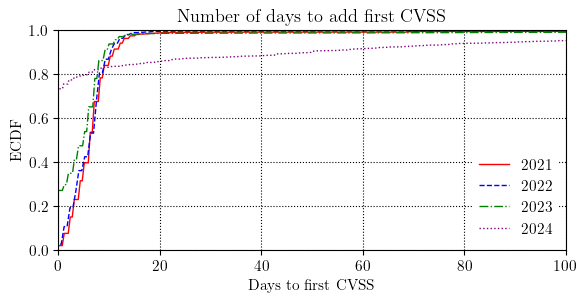

2021 6.0
2022 6.0
2023 5.0
2024 0.0


In [25]:
data = [(str(y), df_cvss.dropna(subset=['daysToCVSS']).groupby('reservationYear')['daysToCVSS'].apply(list)[y]) for y in range(2021, 2025)]
plot = fastplot.plot(data, None, mode='CDF_multi', xlabel='Days to first CVSS', xlim=(0, 100), 
                     ylabel='ECDF', legend=True, **PLOT_ARGS)
plot.title('Number of days to add first CVSS')
plot.show()

for e in data:
    print(e[0], statistics.median(e[1]))

In [26]:
times = df_cvss[df_cvss.reservationYear == 2024].dropna(subset=['daysToCVSS'])
times[times.daysToCVSS > 0].id.nunique() / times.id.nunique() * 100

26.66700369040999

<Figure size 640x480 with 0 Axes>

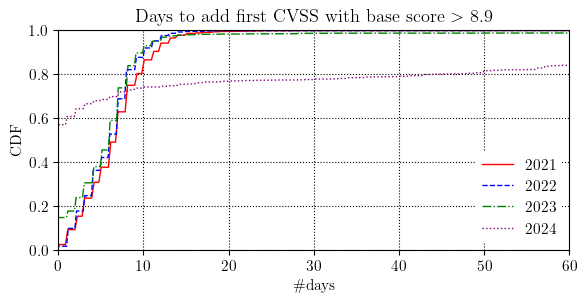

In [27]:
df = df_cvss.dropna(subset=['cvssCreated', 'cvssBaseScore'])
df = df[df['cvssBaseScore'] > 8.9]
data = [(str(y), df.groupby('reservationYear')['daysToCVSS'].apply(list)[y]) for y in YEARS]
plot = fastplot.plot(data, None, mode='CDF_multi', xlim=(0, 60), xlabel='\#days', legend=True, **PLOT_ARGS)
plot.title('Days to add first CVSS with base score $>$ 8.9')
plot.show()

<Figure size 640x480 with 0 Axes>

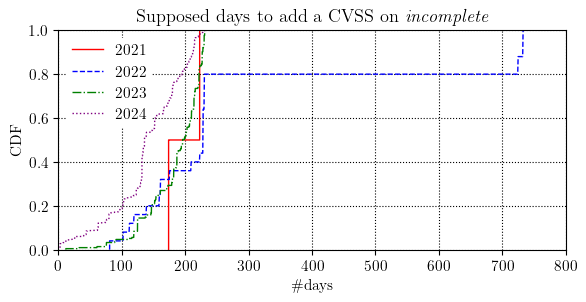

In [28]:
df_no_cvss = df_cvss[df_cvss['cvssVersion'].isna()].copy()
df_no_cvss['supposedDaysToCVSS'] = (DAY_UPPER_BOUND - df_no_cvss['published'].dt.date).dt.days
data = [(str(y), df_no_cvss.groupby('reservationYear')['supposedDaysToCVSS'].apply(list)[y]) for y in YEARS]
plot = fastplot.plot(data, None, mode='CDF_multi', xlabel='\#days', legend=True, **PLOT_ARGS)
plot.title('Supposed days to add a CVSS on \\textit{incomplete}')
plot.show()

### Focus on CVE with CVSS on 2024

<Figure size 640x480 with 0 Axes>

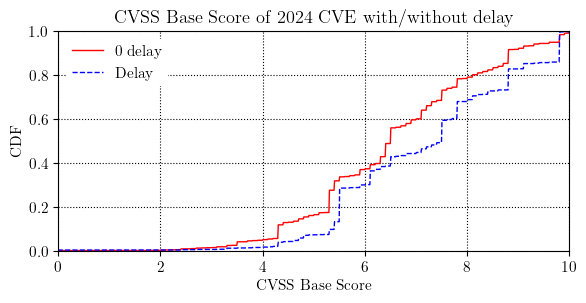

0 delay: 14506
Delay: 5275


In [29]:
df_cvss_2024 = df_cvss[df_cvss.reservationYear == 2024].dropna(subset=['daysToCVSS', 'cvssBaseScore'])
data = [('0 delay', df_cvss_2024[df_cvss_2024.daysToCVSS == 0]['cvssBaseScore'].values), 
        ('Delay', df_cvss_2024[df_cvss_2024.daysToCVSS > 0]['cvssBaseScore'].values)]
plot = fastplot.plot(data, None, mode='CDF_multi', xlabel='CVSS Base Score', legend=True, **PLOT_ARGS)
plot.title('CVSS Base Score of 2024 CVE with/without delay')
plot.show()
for e in data:
    print(f'{e[0]}: {len(e[1])}')

In [30]:
df_cvss_2024 = df_cvss[df_cvss.reservationYear == 2024]
df_cvss_2024_data = df_cvss_2024.groupby(df_cvss_2024['published'].dt.month)['cvssVersion'].agg(
    no_cvss=lambda x: x.isna().sum(),
    cvss=lambda x: x.notna().sum()
)

<Figure size 640x480 with 0 Axes>

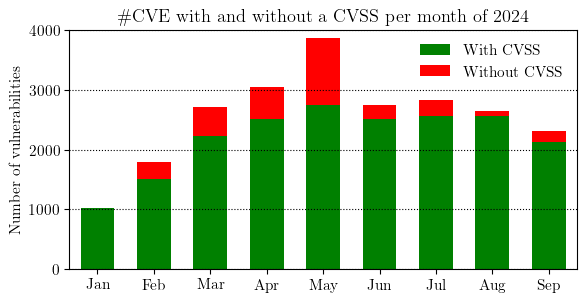

In [31]:
data = pd.DataFrame([[df_cvss_2024_data[df_cvss_2024_data.index == i].cvss.values[0], df_cvss_2024_data[df_cvss_2024_data.index == i].no_cvss.values[0]] for i in range (1, 10)], 
                    index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], 
                    columns=['With CVSS', 'Without CVSS'])

cc = (cycler('color',['g', 'r']))

plot = fastplot.plot(data, None, mode='bars_stacked', ylabel='Number of vulnerabilities', cycler=cc, 
                     grid_axis='y', legend=True, **PLOT_ARGS)
plot.title('\#CVE with and without a CVSS per month of 2024')
plot.show()

           no_cvss  cvss  total  perc_no_cvss  perc_cvss
published                                               
1                0  1019   1019          0.00     100.00
2              277  1507   1784         15.53      84.47
3              480  2232   2712         17.70      82.30
4              528  2519   3047         17.33      82.67
5             1116  2747   3863         28.89      71.11
6              239  2513   2752          8.68      91.32
7              269  2567   2836          9.49      90.51
8               90  2554   2644          3.40      96.60
9              191  2124   2315          8.25      91.75


<Figure size 640x480 with 0 Axes>

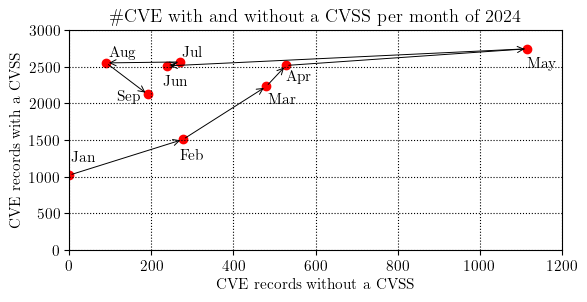

In [32]:
def cvss_scatter_arrow_callback(plt):
    df = df_cvss_2024_data
    df['total'] = df['no_cvss'] + df['cvss']
    df['perc_no_cvss'] = round(df['no_cvss'] / df['total'] * 100, 2)
    df['perc_cvss'] = round(df['cvss'] / df['total'] * 100, 2)
    
    x = df.no_cvss.tolist()
    y = df.cvss.tolist()
    plt.scatter(x, y)
    labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
    for i, label in enumerate(labels):
        if label == 'Jan':
            xyt = (1, 9)
        elif label == 'Feb':
            xyt = (-2, -14)
        elif label == 'Mar':
            xyt = (1, -13)
        elif label == 'Apr':
            xyt = (0, -11)
        elif label == 'May':
            xyt = (0, -13)
        elif label == 'Jun':
            xyt = (-3, -14)
        elif label == 'Jul':
            xyt = (2, 4)
        elif label == 'Aug':
            xyt = (2, 5)
        elif label == 'Sep':
            xyt = (-22, -4)
        plt.annotate(label, (x[i], y[i]), xytext=xyt, textcoords='offset points')
    for i in range(len(x) - 1):
        plt.annotate('', xy=(x[i+1], y[i+1]), xytext=(x[i], y[i]),
                     arrowprops=dict(arrowstyle="->", lw=0.7))
    print(df)
    

plot = fastplot.plot(None, None, mode='callback', callback=cvss_scatter_arrow_callback, xlabel='CVE records without a CVSS', 
                     ylabel='CVE records with a CVSS', ylim=(0, 3000), **PLOT_ARGS)
plot.title('\#CVE with and without a CVSS per month of 2024')
plot.show()

In [33]:
df_cvss_2024 = df_cvss[df_cvss.reservationYear == 2024]
df = df_cvss_2024.groupby(df_cvss_2024['published'].dt.month)['cvssVersion'].agg(
        no_cvss=lambda x: x.isna().sum(),
        cvss=lambda x: x.notna().sum()
    )
tot_cve_2024 = df_cvss_2024.id.nunique()
print(f'CVSS {round(df.cvss.sum() / tot_cve_2024 * 100, 2)} ({df.cvss.sum()})')
print(f'No CVSS {round(df.no_cvss.sum() / tot_cve_2024 * 100, 2)} ({df.no_cvss.sum()})')

CVSS 86.11 (19782)
No CVSS 13.89 (3190)


## CPE

In [34]:
df_info_cpe = pd.read_csv(f'{dataset_path}/cve_info_21-24_cpe_f.csv')
df_info_cpe['reserved'] = pd.to_datetime(df_info_cpe['reserved'], utc=True).dt.tz_localize(None)
df_info_cpe['published'] = pd.to_datetime(df_info_cpe['published']).dt.tz_localize(None)
df_info_cpe['rejected'] = pd.to_datetime(df_info_cpe['rejected']).dt.tz_localize(None)

df_info_cpe = df_info_cpe[df_info_cpe.reservationYear > 2020]
df_info_cpe = df_info_cpe.loc[(df_info_cpe['reserved'] < df_info_cpe['published']) | (df_info_cpe['reserved'].isna())]
df_info_cpe = df_info_cpe[~df_info_cpe['id'].isin(id_rejected)]

df_changes_cpe = df_changes[(df_changes['changeType'] == 'CPE') &\
                            (df_changes['action'].astype(str).str.contains('Added'))][['cveId', 'created', 'newValue']]
df_changes_cpe.newValue = df_changes_cpe.newValue.str.strip('\n')
df_changes_cpe.dropna(subset=['newValue'], inplace=True)

df_changes_cpe.sort_values(['cveId', 'created'], ascending=[True, True], inplace=True)
df_first_cpe = df_changes_cpe.loc[df_changes_cpe.groupby('cveId').head(1).index]

df_first_cpe.rename(columns={'cveId': 'id', 'newValue': 'cpe', 'created': 'cpeCreated'}, inplace=True)

missing_cpe = set(df_changes.cveId) - set(df_first_cpe.id)
df_info_cpe_merging = df_info_cpe[df_info_cpe.id.isin(missing_cpe)].drop_duplicates(subset=['id'])[['id', 'cpe']]
df_cpe = pd.merge(df_first_cpe, df_info_cpe_merging, how='outer')

df_info_cpe_merging = df_info_cpe.drop_duplicates(subset=['id'])[['id', 'reserved', 'reservationYear', 'published']]
df_cpe = pd.merge(df_cpe, df_info_cpe_merging, on=['id'], how='inner')

df_cpe['daysToCPE'] = (df_cpe['cpeCreated'].dt.date - df_cpe['published'].dt.date).dt.days

print(df_cpe.info())
without_date_cpe = len(df_cpe.dropna(subset=['cpe']).cpe) - len(df_cpe.dropna(subset=['cpeCreated']).cpeCreated)
print(f'\nWithout cpeCreated: {round(without_date_cpe / len(df_cpe.dropna(subset=["cpe"]).cpe) * 100, 2)}% ({without_date_cpe})')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94949 entries, 0 to 94948
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               94949 non-null  object        
 1   cpeCreated       75813 non-null  datetime64[ns]
 2   cpe              76903 non-null  object        
 3   reserved         94454 non-null  datetime64[ns]
 4   reservationYear  94949 non-null  int64         
 5   published        94949 non-null  datetime64[ns]
 6   daysToCPE        75813 non-null  float64       
dtypes: datetime64[ns](3), float64(1), int64(1), object(2)
memory usage: 5.8+ MB
None

Without cpeCreated: 1.42% (1090)


### Main analysis

[('2021', 63), ('2022', 151), ('2023', 3024), ('2024', 14808)]


<Figure size 640x480 with 0 Axes>

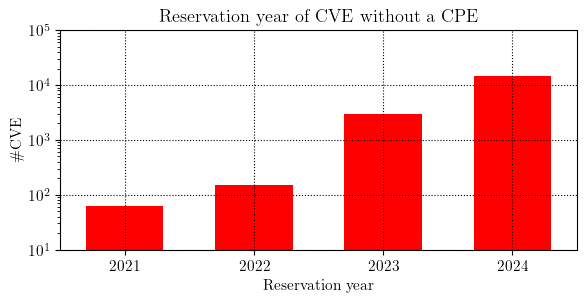

<Figure size 640x480 with 0 Axes>

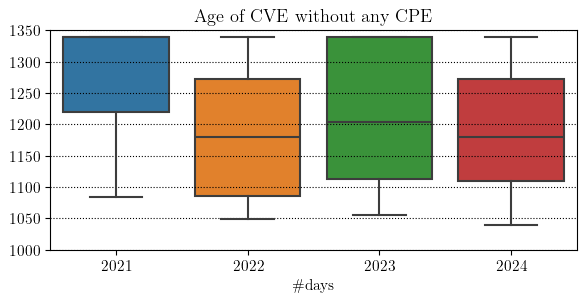

In [35]:
df_info_cpe_no_cpe = df_cpe[df_cpe.cpe.isna()]

no_cpe_size = df_info_cpe_no_cpe.groupby('reservationYear').size()
data = [(str(y), no_cpe_size[y]) for y in YEARS]
print(data)
plot = fastplot.plot(data, None, mode='bars', xlabel='Reservation year', ylabel='\#CVE', yscale='log', **PLOT_ARGS)
plot.title('Reservation year of CVE without a CPE')
plot.show()

df_age = df_info_cpe_no_cpe.copy()
df_age['age'] = (DAY_UPPER_BOUND - df_info_cpe['reserved'].dt.date).dt.days
data = [(str(y), df_age.groupby('reservationYear')['age'].apply(list)[y]) for y in YEARS]
plot = fastplot.plot(data, None, mode='boxplot', xlabel='\#days', **PLOT_ARGS)
plot.title('Age of CVE without any CPE')
plot.show()

<Figure size 640x480 with 0 Axes>

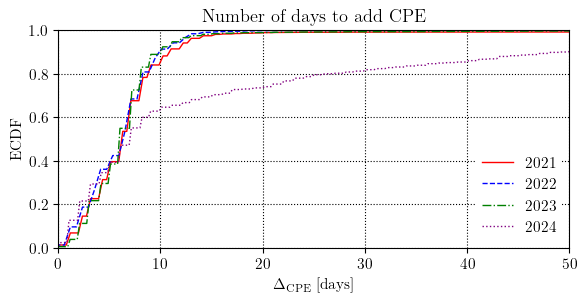

2021 6.0
2022 6.0
2023 6.0
2024 7.0


In [36]:
data = [(str(y), df_cpe.dropna(subset=['daysToCPE']).groupby('reservationYear')['daysToCPE'].apply(list)[y]) for y in YEARS]
plot = fastplot.plot(data, None, mode='CDF_multi', xlabel='$\\Delta_{\\text{CPE}}$ [days]', xlim=(0, 50), 
                     ylabel='ECDF', legend=True, **PLOT_ARGS)
plot.title('Number of days to add CPE')
plot.show()
for e in data:
    print(e[0], statistics.median(e[1]))

<Figure size 640x480 with 0 Axes>

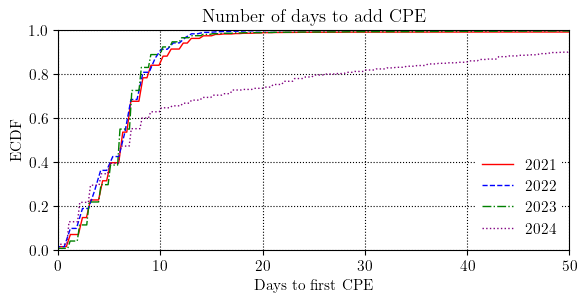

2021 6.0
2022 6.0
2023 6.0
2024 7.0


In [37]:
data = [(str(y), df_cpe.dropna(subset=['daysToCPE']).groupby('reservationYear')['daysToCPE'].apply(list)[y]) for y in YEARS]
plot = fastplot.plot(data, None, mode='CDF_multi', xlabel='Days to first CPE', xlim=(0, 50), 
                     ylabel='ECDF', legend=True, **PLOT_ARGS)
plot.title('Number of days to add CPE')
plot.show()
for e in data:
    print(e[0], statistics.median(e[1]))

<Figure size 640x480 with 0 Axes>

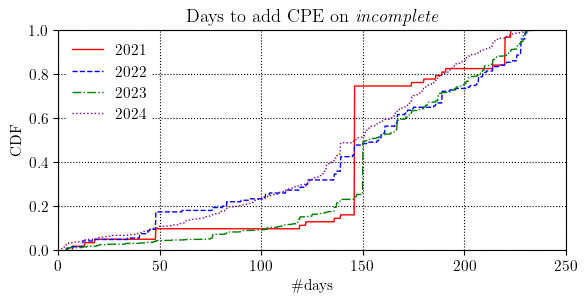

In [38]:
df_info_cpe_no_cpe = df_cpe[df_cpe.cpe.isna()].copy()
df_info_cpe_no_cpe['supposedDaysToCPE'] = (DAY_UPPER_BOUND - df_info_cpe_no_cpe['published'].dt.date).dt.days
data = [(str(y), df_info_cpe_no_cpe.groupby('reservationYear')['supposedDaysToCPE'].apply(list)[y]) for y in YEARS]
plot = fastplot.plot(data, None, mode='CDF_multi', xlabel='\#days', legend=True, **PLOT_ARGS)
plot.title('Days to add CPE on \\textit{incomplete}')
plot.show()

### Focus on CVE with CPE in 2024

In [39]:
df_cpe_2024 = df_cpe[df_cpe.reservationYear == 2024]
df_cpe_2024_data = df_cpe_2024.groupby(df_cpe_2024['published'].dt.month)['cpe'].agg(
    no_cpe=lambda x: x.isna().sum(),
    cpe=lambda x: x.notna().sum()
)

<Figure size 640x480 with 0 Axes>

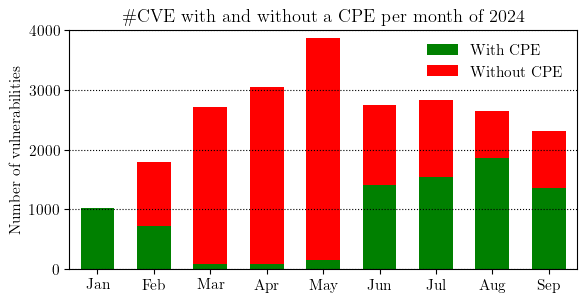

In [40]:
data = pd.DataFrame([[df_cpe_2024_data[df_cpe_2024_data.index == i].cpe.values[0], df_cpe_2024_data[df_cpe_2024_data.index == i].no_cpe.values[0]] for i in range (1, 10)], 
                    index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], 
                    columns=['With CPE', 'Without CPE'])

cc = (cycler('color',['g', 'r']))

plot = fastplot.plot(data, None, mode='bars_stacked', ylabel='Number of vulnerabilities', cycler=cc, 
                     grid_axis='y', legend=True, **PLOT_ARGS)
plot.title('\#CVE with and without a CPE per month of 2024')
plot.show()

           no_cpe   cpe  total  perc_no_cpe  perc_cpe
published                                            
1               0  1019   1019         0.00    100.00
2            1075   709   1784        60.26     39.74
3            2630    82   2712        96.98      3.02
4            2974    73   3047        97.60      2.40
5            3722   141   3863        96.35      3.65
6            1345  1407   2752        48.87     51.13
7            1303  1533   2836        45.94     54.06
8             793  1851   2644        29.99     70.01
9             966  1349   2315        41.73     58.27


<Figure size 640x480 with 0 Axes>

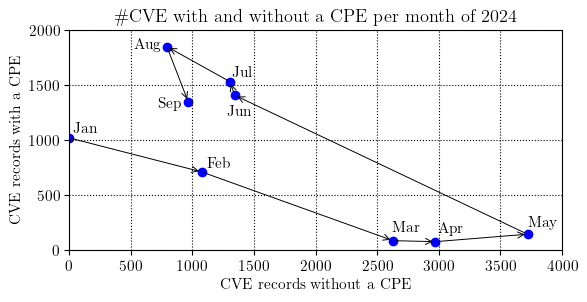

In [41]:
def cpe_scatter_arrow_callback(plt):
    df = df_cpe_2024_data.copy()
    df['total'] = df['no_cpe'] + df['cpe']
    df['perc_no_cpe'] = round(df['no_cpe'] / df['total'] * 100, 2)
    df['perc_cpe'] = round(df['cpe'] / df['total'] * 100, 2)
    
    x = df.no_cpe.tolist()
    y = df.cpe.tolist()
    plt.scatter(x, y, c='blue')
    labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
    for i, label in enumerate(labels):
        if label == 'Jan':
            xyt = (3, 3)
        elif label == 'Feb':
            xyt = (4, 3)
        elif label == 'Mar':
            xyt = (-1, 6)
        elif label == 'Apr':
            xyt = (2, 7)
        elif label == 'May':
            xyt = (0, 6)
        elif label == 'Jun':
            xyt = (-6, -14)
        elif label == 'Jul':
            xyt = (2, 4)
        elif label == 'Aug':
            xyt = (-24, -1)
        elif label == 'Sep':
            xyt = (-22, -4)
        plt.annotate(label, (x[i], y[i]), xytext=xyt, textcoords='offset points')
    for i in range(len(x) - 1):
        plt.annotate('', xy=(x[i+1], y[i+1]), xytext=(x[i], y[i]),
                     arrowprops=dict(arrowstyle="->", lw=0.7))
    print(df)

plot = fastplot.plot(None, None, mode='callback', callback=cpe_scatter_arrow_callback,
                     xlabel='CVE records without a CPE', ylabel='CVE records with a CPE', **PLOT_ARGS)
plot.title('\#CVE with and without a CPE per month of 2024')
plot.show()

In [42]:
df_cpe_2024 = df_cpe[df_cpe.reservationYear == 2024]
df = df_cpe_2024.groupby(df_cpe_2024['published'].dt.month)['cpe'].agg(
    no_cpe=lambda x: x.isna().sum(),
    cpe=lambda x: x.notna().sum()
)
tot_cve_2024 = df_cpe_2024.id.nunique()
print(f'CPE {round(df.cpe.sum() / tot_cve_2024 * 100, 2)} ({df.cpe.sum()})')
print(f'No CPE {round(df.no_cpe.sum() / tot_cve_2024 * 100, 2)} ({df.no_cpe.sum()})')

CPE 35.54 (8164)
No CPE 64.46 (14808)


## Data noise

### Missing reservartion and creation dates

In [43]:
df_first_info = pd.merge(df_cvss, df_cpe, on=['id', 'reserved', 'published', 'reservationYear'], suffixes=('_cvss', '_cpe'))
df_first_info = df_first_info.rename(columns={
    'created_cvss': 'cvssCreated',
    'created_cpe': 'cpeCreated'
})

df_first_info = pd.merge(df_first_info, 
                         df_info_cvss.drop_duplicates(subset=['id'])[['id', 'description']],
                         on=['id'],
                         how='inner')

In [44]:
df = df_first_info[df_first_info.reserved.isna()]
print('Missing reservation dates', df.id.nunique())
df.groupby('reservationYear').size()

Missing reservation dates 495


reservationYear
2022     13
2023     32
2024    450
dtype: int64

In [45]:
df = df_first_info[(~df_first_info.cvssVersion.isna()) & (df_first_info.cvssCreated.isna())]
print('CVSS without creation date', df.id.nunique())
df.groupby('reservationYear').size()

CVSS without creation date 2396


reservationYear
2021     177
2022    1124
2023    1094
2024       1
dtype: int64

In [46]:
df = df_first_info[(~df_first_info.cpe.isna()) & (df_first_info.cpeCreated.isna())]
print('CPE without creation date', df.id.nunique())
df.groupby('reservationYear').size()

CPE without creation date 1090


reservationYear
2021    233
2022    332
2023    399
2024    126
dtype: int64

### Do the publication dates match between "info" and "feed"?

<Figure size 640x480 with 0 Axes>

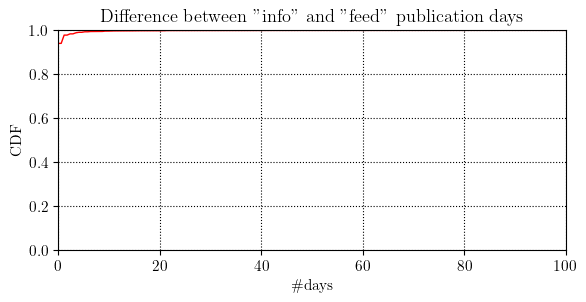

In [47]:
df_pub_date = df_info_cvss[['id', 'published']].drop_duplicates(subset=['id']).merge(df_feed[['id', 'published']], 
                                                                                on=['id'], 
                                                                                how='inner',
                                                                                suffixes=['_info', '_feed'])
df_pub_date['publishDiff'] = abs((df_pub_date['published_info'].dt.date - df_pub_date['published_feed'].dt.date).dt.days)
df_pub_date_nonan = df_pub_date.dropna()

plot = fastplot.plot(df_pub_date_nonan['publishDiff'], None, mode='CDF', xlabel='\#days', xlim=(0, 100), **PLOT_ARGS)
plot.title('Difference between "info" and "feed" publication days')
plot.show()

In [48]:
print(len(df_pub_date[df_pub_date.publishDiff > 0]))
print(df_pub_date[df_pub_date.publishDiff > 0].publishDiff.median())
print(df_pub_date[df_pub_date.publishDiff > 0].publishDiff.max())
print(len(df_pub_date[df_pub_date.publishDiff > 7].publishDiff))

5632
1.0
579.0
515
